**Target :**
Achieve Model accuracy 99.4 at least once 

**Constraint :**

Use less than 8 k paramter
Use less than 15 epochs 


**Parameters used :**7736

**Technique :**
Technique same as s5_Drill_03.ipynb




**Technique 1 :** step_size=6 with Step LR 

Best Train acc :99.21
Best test acc: 99.36

**Technique 2 :** Technique 2 : step_size=8 with Step LR 

Best Train acc :99.32
Best test acc: 99.38

**Technique 3 :**  step_size=10 with Step LR 

Best Train acc :99.35
Best test acc: 99.48 (99.4 more than 6 times out of 15 times)


#TARGET ACHIEVED 

In [20]:
# Import Libraries

In [21]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [22]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [23]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [24]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.4213)
 - std: tensor(0.0889)
 - var: tensor(0.0079)
torch.Size([128, 1, 28, 28])
torch.Size([128])


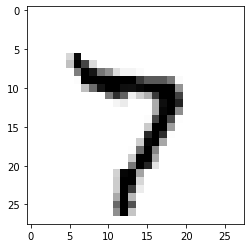

In [25]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

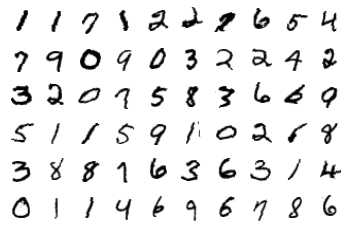

In [26]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [27]:

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(10),
        nn.ReLU(),
        #nn.Dropout(0.1),
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    # Transition Block 1
    self.transitionblock1 = nn.Sequential(
        nn.Conv2d(in_channels = 16,out_channels = 8,kernel_size = (1,1),padding = 0,bias = False),
        nn.MaxPool2d(2,2)
    )

    # Convolution Block 3
    self.convblock3= nn.Sequential(
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    # Convolution Block 4
    self.convblock4= nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    self.convblock5= nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=6),
        nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(1,1),padding = 0, bias = True)
    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.transitionblock1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.gap(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim = -1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [28]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,440
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
            Conv2d-7            [-1, 8, 24, 24]             128
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           1,152
      BatchNorm2d-10           [-1, 16, 10, 10]              32
             ReLU-11           [-1, 16, 10, 10]               0
           Conv2d-12             [-1, 16, 8, 8]           2,304
      BatchNorm2d-13             [-1, 16, 8, 8]              32
             ReLU-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [29]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    tqdm._instances.clear()


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [30]:
# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
# for epoch in range(EPOCHS):
#     print("EPOCH:", epoch)
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)

from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.18703478574752808 Batch_id=468 Accuracy=83.52: 100%|██████████| 469/469 [00:24<00:00, 19.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1549, Accuracy: 9625/10000 (96.25%)

EPOCH: 2


Loss=0.1359143704175949 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:24<00:00, 19.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1313, Accuracy: 9619/10000 (96.19%)

EPOCH: 3


Loss=0.027528852224349976 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:24<00:00, 19.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.03951641544699669 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9866/10000 (98.66%)

EPOCH: 5


Loss=0.05115892365574837 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:24<00:00, 19.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9855/10000 (98.55%)

EPOCH: 6


Loss=0.024169601500034332 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:23<00:00, 19.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9896/10000 (98.96%)

EPOCH: 7


Loss=0.03746103122830391 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:23<00:00, 19.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.02162637747824192 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:23<00:00, 19.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.053452715277671814 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:23<00:00, 19.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.007248852401971817 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.06631862372159958 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.021182863041758537 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.017299091443419456 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:22<00:00, 20.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.006264209747314453 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:23<00:00, 20.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.05101591721177101 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s]



Test set: Average loss: 0.0238, Accuracy: 9929/10000 (99.29%)



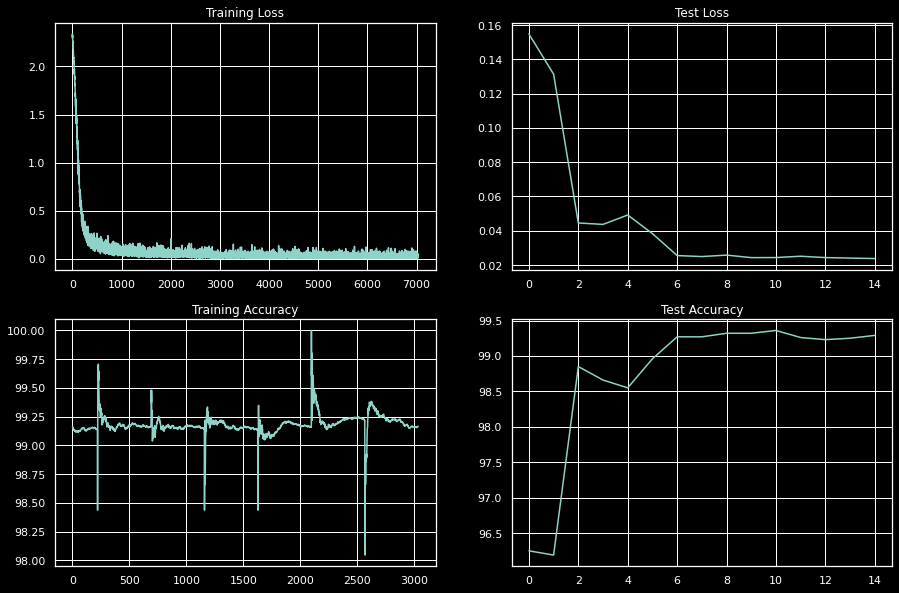

In [31]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [32]:
#LETS TRY WITH STEP SIZE 8
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.12767387926578522 Batch_id=468 Accuracy=82.47: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1198, Accuracy: 9727/10000 (97.27%)

EPOCH: 2


Loss=0.0552743524312973 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1140, Accuracy: 9655/10000 (96.55%)

EPOCH: 3


Loss=0.08050165325403214 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:22<00:00, 21.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9887/10000 (98.87%)

EPOCH: 4


Loss=0.05382689833641052 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.07433393597602844 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9846/10000 (98.46%)

EPOCH: 6


Loss=0.07802236825227737 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:22<00:00, 21.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9901/10000 (99.01%)

EPOCH: 7


Loss=0.018674613907933235 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:21<00:00, 21.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.04215298220515251 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:21<00:00, 21.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9903/10000 (99.03%)

EPOCH: 9


Loss=0.05518312752246857 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:21<00:00, 21.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.07993172854185104 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.018934031948447227 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:21<00:00, 21.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.04261597990989685 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.029920430853962898 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.06605439633131027 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:21<00:00, 21.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.009101060219109058 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]



Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)



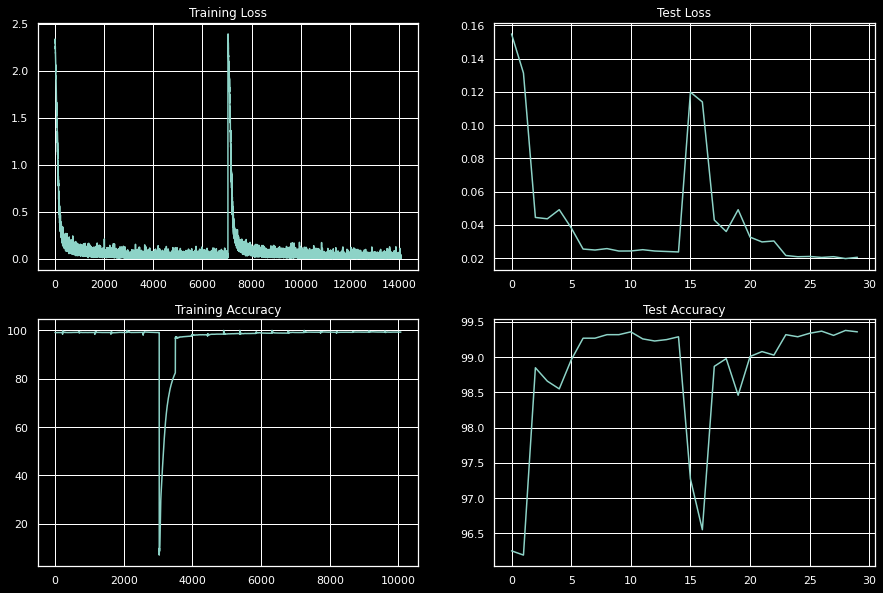

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [34]:
#LETS TRY WITH STEP SIZE 10
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.17737539112567902 Batch_id=468 Accuracy=83.68: 100%|██████████| 469/469 [00:21<00:00, 21.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1016, Accuracy: 9770/10000 (97.70%)

EPOCH: 2


Loss=0.10189863294363022 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0670, Accuracy: 9828/10000 (98.28%)

EPOCH: 3


Loss=0.09983661770820618 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.04496337100863457 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9875/10000 (98.75%)

EPOCH: 5


Loss=0.06902896612882614 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.022217661142349243 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


Loss=0.06701447069644928 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.008077257312834263 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.022646302357316017 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.04637136682868004 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.017173809930682182 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:21<00:00, 21.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9945/10000 (99.45%)

EPOCH: 12


Loss=0.023063307628035545 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.01506671030074358 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


Loss=0.010853643529117107 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:20<00:00, 22.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Loss=0.03216862305998802 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]



Test set: Average loss: 0.0183, Accuracy: 9948/10000 (99.48%)



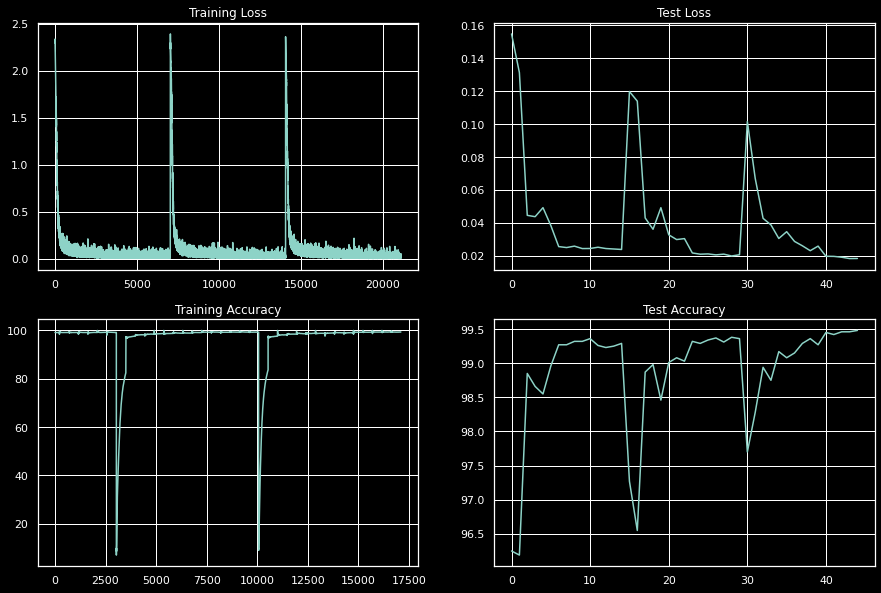

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()